In [3]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
from pathlib import Path

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Your Question Data

In [4]:
# question path
questions_file_path = Path("/Volumes/MACBACKUP/train_ellie_questions.csv")

In [5]:
try:
    df_ellie = pd.read_csv(questions_file_path)
    
    # Get a list of all unique questions from the 4th column ('value')
    unique_questions = df_ellie['value'].str.lower().str.strip().drop_duplicates().tolist()
    
    # Filter out single-word questions and non-string data
    filtered_questions = [
        q for q in unique_questions 
        if isinstance(q, str) and len(q.split()) > 1
    ]
    
    print(f"Loaded {len(unique_questions)} unique lines, filtered down to {len(filtered_questions)} multi-word questions.")

except FileNotFoundError:
    print(f"Error: {questions_file_path} not found.")
    filtered_questions = []

Loaded 349 unique lines, filtered down to 328 multi-word questions.


Loading Sentence Transformer model (this may take a moment)...
Creating embeddings for all unique questions...
Embedding creation complete.
Running Elbow Method to find optimal k...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Plotting Elbow Method. Look for the 'elbow' in the plot to find the best k.


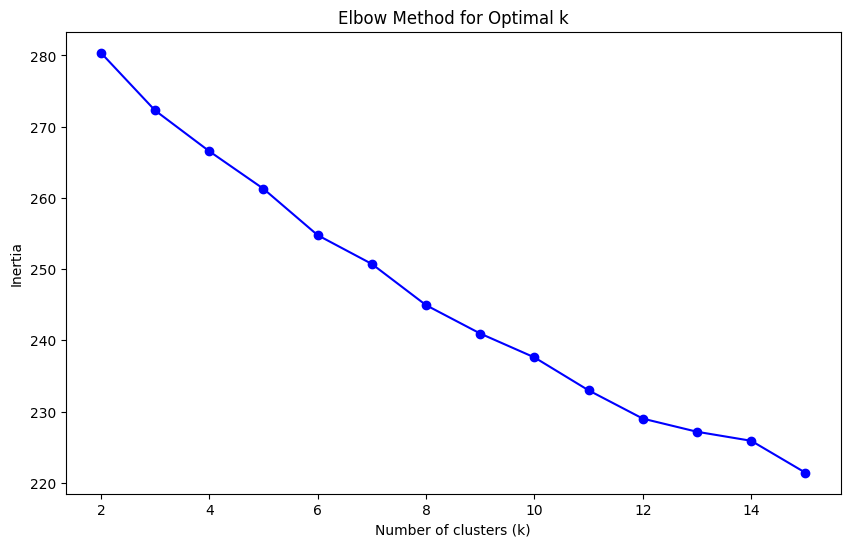


   FINAL LIST OF 12 REPRESENTATIVE QUESTIONS
Cluster 1: what did you do after the military
Cluster 2: that's good
Cluster 3: tell_me_about (tell me about that)
Cluster 4: why_la (why did you move to l_a)
Cluster 5: therapy_changes (what sort of changes have you noticed since you've been going to therapy)
Cluster 6: ellie17dec2012_02 (uh huh)
Cluster 7: do you feel that way often
Cluster 8: parent_hardest (what's the hardest thing about being a parent)
Cluster 9: and please feel free to tell me anything you're answers are totally confidential
Cluster 10: uh_oh (uh oh)
Cluster 11: how close are you to your family <asks do you travel a lot simultaneously>
Cluster 12: okay


In [6]:
if unique_questions:
    # Creating Semantic Embeddings
    print("Loading Sentence Transformer model (this may take a moment)...")
    model = SentenceTransformer('all-MiniLM-L6-v2') 

    print("Creating embeddings for all unique questions...")
    question_embeddings = model.encode(unique_questions)
    print("Embedding creation complete.")

    # Finding Optimal 'k' with the Elbow Method
    print("Running Elbow Method to find optimal k...")
    inertia = []
    
    # Test a range of k values (e.g., from 2 up to 15)
    max_k = min(15, len(unique_questions) - 1)
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(question_embeddings)
        inertia.append(kmeans.inertia_)

    # Plotting the Elbow Method
    print("Plotting Elbow Method. Look for the 'elbow' in the plot to find the best k.")
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    # Run Final Clustering
    
    # Look at the plot above. Find the "elbow" (the point where the
    # line stops dropping sharply) and enter that number below.
    # I'll use 8 as a default, but you should change this.
    
    optimal_k = 12
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans.fit(question_embeddings)

    # Get the Most Representative Question from Each Cluster
    # This finds the index of the question in each cluster that is closest to the center
    closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, question_embeddings)
    
    final_question_list = [unique_questions[i] for i in closest_indices]

    print("\n" + "="*50)
    print(f"   FINAL LIST OF {optimal_k} REPRESENTATIVE QUESTIONS")
    print("="*50)
    for i, q in enumerate(final_question_list):
        print(f"Cluster {i+1}: {q}")